In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import Constant

In [31]:
# 데이터 불러오기
train_data = pd.read_table('/aiffel/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/aiffel/aiffel/sentiment_classification/data/ratings_test.txt')

# 형태소 분석을 위한 Mecab 토크나이저 사용
tokenizer = Mecab()

# 불용어 정의
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

# 데이터셋 내 문장 길이 분포 확인을 위한 최대 길이 설정
max_len = 30  # 예시로 30으로 설정

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 전처리 과정

데이터의 중복을 제거하고 NaN 결측치를 제거한다. 한국어 토크나이저로 토큰화를 하고 위에서 정의했던 불용어 'stopwords'에 들어간 글자들을 제거한다. 그리고 'word_to_index' 구성하고 텍스트 스트링을 사전 인덱스 스트링으로 변환한다.

In [3]:
# 데이터 전처리 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거 후 리스트에 저장
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    # 단어 빈도수 계산 및 상위 빈도 단어로 vocab 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # 단어를 인덱스로 변환하는 함수 정의
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    # 훈련 및 테스트 데이터를 인덱스로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # 패딩을 적용하여 시퀀스의 길이를 일정하게 조정
    return (
        pad_sequences(X_train, maxlen=max_len),
        np.array(list(train_data['label'])),
        pad_sequences(X_test, maxlen=max_len),
        np.array(list(test_data['label'])),
        word_to_index
    )

# 데이터 전처리 한 함수를 호출하여 데이터셋 생성 후 데이터 분리

In [4]:
# 데이터 전처리 함수 호출하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

# 훈련 데이터를 검증 데이터와 학습 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model 1: Simple LSTM

model_lstm.add(LSTM(128)) 유닛값을 높혔을 때 accuracy가 조금 더 높게 나왔다. 그래서 Layer 추가나 다른 하이퍼파라미터의 조정을 해보려고 했으나 시간이 많이 걸려서 시도해보지 못했다. 결론적으로는 유닛값 128, 그리고 에폭 수 3일 때가 제일 좋은 점수가 나왔던 것 같다.

In [5]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(word_to_index), output_dim=100, input_length=max_len))
model_lstm.add(LSTM(128)) 
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           999700    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,117,077
Trainable params: 1,117,077
Non-trainable params: 0
_________________________________________________________________


에폭 수를 1부터 30까지 반복해가면서 시도해봤으나 에폭이 낮을수록 좋은 점수가 나와서 3으로 저장했다.

In [6]:
# 각 모델을 훈련
epochs = 3  # 에폭 수 조절 가능
batch_size = 64

history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/3
1828/1828 [==============================] - 42s 6ms/step - loss: 0.3777 - accuracy: 0.8305 - val_loss: 0.3286 - val_accuracy: 0.8563
Epoch 2/3
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2933 - accuracy: 0.8746 - val_loss: 0.3150 - val_accuracy: 0.8624
Epoch 3/3
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2531 - accuracy: 0.8944 - val_loss: 0.3220 - val_accuracy: 0.8636


In [7]:
print(history_lstm.history)

{'loss': [0.37774431705474854, 0.2933211922645569, 0.2530708611011505], 'accuracy': [0.8304502367973328, 0.8745564222335815, 0.8944461345672607], 'val_loss': [0.32859763503074646, 0.31500187516212463, 0.3219832181930542], 'val_accuracy': [0.8563122153282166, 0.8623661994934082, 0.8635975122451782]}


# Model 2: Bidirectional LSTM
노드에서 잠깐 스쳐간 모델로 일반적인 LSTM 모델들과는 다르게 순방향(왼쪽에서 오른쪽)뿐만 아니라 역방향으로도 정보를 추출할 수 있는 양방향 LSTM 모델이여서 사용해보았다. 하지만 기본 LSTM 모델보다는 accuracy가 계속 낮게 나와서 마냥 좋은 모델이라고는 할 수 없었다.

In [8]:
model_bidirectional_lstm = Sequential()
model_bidirectional_lstm.add(Embedding(input_dim=len(word_to_index), output_dim=100, input_length=max_len))
model_bidirectional_lstm.add(Bidirectional(LSTM(64)))
model_bidirectional_lstm.add(Dense(1, activation='sigmoid'))
model_bidirectional_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_bidirectional_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           999700    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,084,309
Trainable params: 1,084,309
Non-trainable params: 0
_________________________________________________________________


In [9]:
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/3
1828/1828 [==============================] - 16s 7ms/step - loss: 0.3791 - accuracy: 0.8295 - val_loss: 0.3323 - val_accuracy: 0.8552
Epoch 2/3
1828/1828 [==============================] - 13s 7ms/step - loss: 0.2951 - accuracy: 0.8738 - val_loss: 0.3201 - val_accuracy: 0.8616
Epoch 3/3
1828/1828 [==============================] - 13s 7ms/step - loss: 0.2525 - accuracy: 0.8948 - val_loss: 0.3281 - val_accuracy: 0.8615


In [10]:
print(history_bidirectional_lstm.history)

{'loss': [0.3791247308254242, 0.2950740158557892, 0.25250184535980225], 'accuracy': [0.8295267224311829, 0.8738381266593933, 0.8948308825492859], 'val_loss': [0.33226171135902405, 0.3201034963130951, 0.3281053304672241], 'val_accuracy': [0.855183482170105, 0.8616136908531189, 0.8615111112594604]}


# Model 3: 1D CNN
제일 성능이 좋지 않았던 모델이였다..

In [11]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(word_to_index), output_dim=100, input_length=max_len))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           999700    
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,063,957
Trainable params: 1,063,957
Non-trainable params: 0
_________________________________________________________________


In [12]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/3
1828/1828 [==============================] - 27s 4ms/step - loss: 0.3747 - accuracy: 0.8324 - val_loss: 0.3291 - val_accuracy: 0.8561
Epoch 2/3
1828/1828 [==============================] - 7s 4ms/step - loss: 0.2684 - accuracy: 0.8887 - val_loss: 0.3241 - val_accuracy: 0.8630
Epoch 3/3
1828/1828 [==============================] - 8s 4ms/step - loss: 0.1932 - accuracy: 0.9253 - val_loss: 0.3599 - val_accuracy: 0.8580


In [13]:
print(history_cnn.history)

{'loss': [0.3747069239616394, 0.2684473991394043, 0.193159818649292], 'accuracy': [0.8323742151260376, 0.888691246509552, 0.9252811074256897], 'val_loss': [0.3290570378303528, 0.32413020730018616, 0.35988473892211914], 'val_accuracy': [0.856141209602356, 0.8630160689353943, 0.8580223917961121]}


# 세개의 모델 accuracy에 대한 시각화

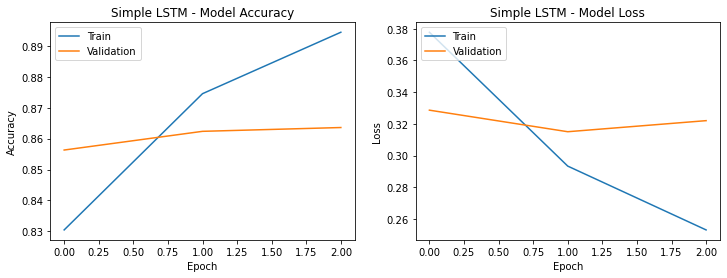

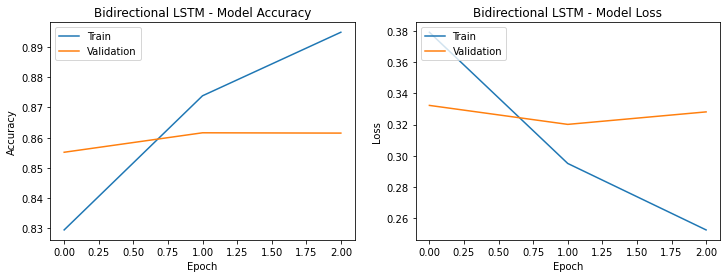

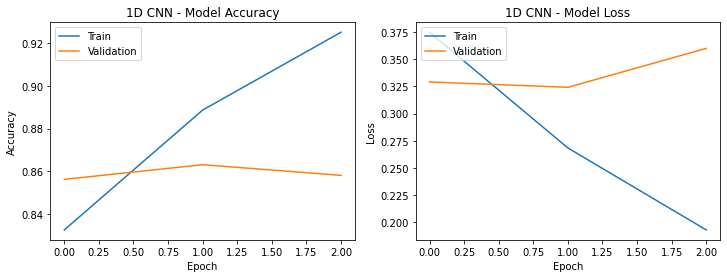

In [14]:
# 시각화 함수 정의
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # 훈련 및 검증 정확도 시각화
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + ' - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 훈련 및 검증 손실 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


# 각 모델의 훈련 히스토리 시각화
plot_history(history_lstm, 'Simple LSTM')
plot_history(history_bidirectional_lstm, 'Bidirectional LSTM')
plot_history(history_cnn, '1D CNN')


# 세 모델의 accuracy 비교
모델 세개는 순서대로 성능이 좋게 나타난 걸 확인할 수 있다.

In [15]:
results = model_lstm.evaluate(X_test, y_test, verbose=2)
results = model_bidirectional_lstm.evaluate(X_test, y_test, verbose=2)
results = model_cnn.evaluate(X_test, y_test, verbose=2)

1537/1537 - 3s - loss: 0.3299 - accuracy: 0.8593
1537/1537 - 4s - loss: 0.3357 - accuracy: 0.8588
1537/1537 - 2s - loss: 0.3676 - accuracy: 0.8544


# 한국어 Word2Vec 활용하여 성능 개선

In [16]:
word2vec = Word2VecKeyedVectors.load(
os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model',
).wv #wv만 가져옴

'컴퓨터'라는 단어와 제일 가까운 유사성을 가진 단어들을 보여준다. 완전 신기!!

In [17]:
word2vec.similar_by_word("컴퓨터")

[('하드웨어', 0.806628942489624),
 ('소프트웨어', 0.7847487330436707),
 ('컴퓨팅', 0.7836830019950867),
 ('노트북', 0.7603618502616882),
 ('가상현실', 0.7591529488563538),
 ('그래픽스', 0.7564041614532471),
 ('메인프레임', 0.7557739019393921),
 ('PC', 0.7514778971672058),
 ('인공지능', 0.7492970824241638),
 ('프린터', 0.7475006580352783)]

'과일'로도 해봤는데 음.. '컴퓨터'의 결과보다는 마음에 들지 않는다..

In [18]:
word2vec.similar_by_word("과일")

[('벌꿀', 0.8761025071144104),
 ('채소', 0.8665552735328674),
 ('생선', 0.8615601658821106),
 ('당근', 0.8559051752090454),
 ('해산물', 0.854114830493927),
 ('옥수수', 0.8461793065071106),
 ('호박', 0.8447818756103516),
 ('야채', 0.8432352542877197),
 ('파인애플', 0.8378430008888245),
 ('생강', 0.8354300260543823)]

이것은 100차원으로 된 임베딩 벡터라는 것을 알 수 있다.

In [20]:
vector = word2vec['컴퓨터']
vector.shape #100차원으로 된 임베딩 벡터

(100,)

임베딩 매트릭스 생성 후 각 행에 Word2Vec 모델에서 가져온 단어 벡터를 할당한다. 이 때 'index_to_word'를 사용하여 현재 인덱스에 해당하는 단어를 찾고, 해당 단어가 Word2Vec 모델에 있는지 확인한다.
이렇게 함으로써 모델은 텍스트 데이터의 단어를 고정된 차원의 밀집 벡터로 효과적으로 표현할 수 있게 된다.

In [21]:
index_to_word = {index: word for word, index in word_to_index.items()}

vocab_size = 10000
word2vec_dim = 100 #가져온 100차원
embedding_matrix = np.random.rand(vocab_size, word2vec_dim)

for i in range(4,vocab_size): #100차원을 임베딩 메트릭스에 값을 넣어줌
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

# Model 1: Simple LSTM
다시 세개의 모델에 대한 학습을 해본다!
이번엔 input_dim을 vocab_size로 넣어주고, output_dim을 word2vec_dim, 그리고 마지막에는 embeddings_initializer=Constant(embedding_matrix)을 추가해준다.
처음 결과보다 조금 더 상승한 accuracy를 얻을 수 있었다!

In [22]:
# Model 1: Simple LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=word2vec_dim, input_length=max_len, embeddings_initializer=Constant(embedding_matrix))) #input_dim -> vocab_size
model_lstm.add(LSTM(128))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/3
1828/1828 [==============================] - 12s 6ms/step - loss: 0.4054 - accuracy: 0.8119 - val_loss: 0.3397 - val_accuracy: 0.8539
Epoch 2/3
1828/1828 [==============================] - 10s 5ms/step - loss: 0.3036 - accuracy: 0.8700 - val_loss: 0.3159 - val_accuracy: 0.8642
Epoch 3/3
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2613 - accuracy: 0.8907 - val_loss: 0.3171 - val_accuracy: 0.8647


# Model 2: Bidirectional LSTM

In [24]:
# Model 2: Bidirectional LSTM
model_bidirectional_lstm = Sequential()
model_bidirectional_lstm.add(Embedding(input_dim=vocab_size, output_dim=word2vec_dim, input_length=max_len, embeddings_initializer=Constant(embedding_matrix)))
model_bidirectional_lstm.add(Bidirectional(LSTM(64)))
model_bidirectional_lstm.add(Dense(1, activation='sigmoid'))
model_bidirectional_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_bidirectional_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,084,609
Trainable params: 1,084,609
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/3
1828/1828 [==============================] - 16s 7ms/step - loss: 0.4154 - accuracy: 0.8063 - val_loss: 0.3507 - val_accuracy: 0.8446
Epoch 2/3
1828/1828 [==============================] - 13s 7ms/step - loss: 0.3137 - accuracy: 0.8641 - val_loss: 0.3302 - val_accuracy: 0.8571
Epoch 3/3
1828/1828 [==============================] - 13s 7ms/step - loss: 0.2758 - accuracy: 0.8844 - val_loss: 0.3314 - val_accuracy: 0.8607


# Model 3: 1D CNN

In [26]:
# Model 3: 1D CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=word2vec_dim, input_length=max_len, embeddings_initializer=Constant(embedding_matrix))) 
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,064,257
Trainable params: 1,064,257
Non-trainable params: 0
_________________________________________________________________


In [27]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/3
1828/1828 [==============================] - 8s 4ms/step - loss: 0.5185 - accuracy: 0.7572 - val_loss: 0.4224 - val_accuracy: 0.8105
Epoch 2/3
1828/1828 [==============================] - 7s 4ms/step - loss: 0.3657 - accuracy: 0.8382 - val_loss: 0.3823 - val_accuracy: 0.8328
Epoch 3/3
1828/1828 [==============================] - 7s 4ms/step - loss: 0.3094 - accuracy: 0.8670 - val_loss: 0.3661 - val_accuracy: 0.8384


# 세 모델의 accuracy 비교

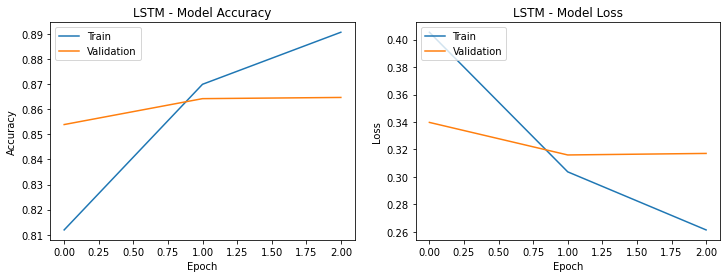

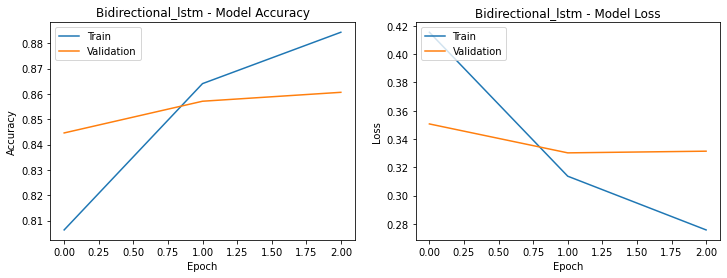

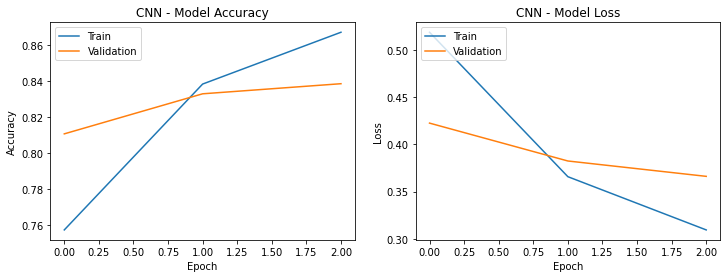

In [28]:
plot_history(history_lstm, 'LSTM')
plot_history(history_bidirectional_lstm, 'Bidirectional_lstm')
plot_history(history_cnn, 'CNN')

처음 결과
LSTM : 0.8579
Bidirectional lstm : 0.8578
CNN : 0.8545

이것과 비교해봤을 때 첫 모델인 LSTM은 accuracy가 거의 86%가까이 상승했으나 Bidirectional LSTM과 CNN은 오히려 낮아지는 결과를 얻을 수 있었다. 결론은 LSTM이 최고..

In [29]:
results = model_lstm.evaluate(X_test, y_test, verbose=2)
results = model_bidirectional_lstm.evaluate(X_test, y_test, verbose=2)
results = model_cnn.evaluate(X_test, y_test, verbose=2)

1537/1537 - 3s - loss: 0.3211 - accuracy: 0.8618
1537/1537 - 4s - loss: 0.3384 - accuracy: 0.8579
1537/1537 - 2s - loss: 0.3741 - accuracy: 0.8360


영화 리뷰라 감정과 관련된 단어인 "감동"을 넣어봤더니 오! 관련된 단어들이 잘 나온다!

In [32]:
word2vec.similar_by_word("감동")

[('감격', 0.8046045899391174),
 ('감탄', 0.7326707243919373),
 ('매혹', 0.7267226576805115),
 ('매력', 0.7088802456855774),
 ('감명', 0.7069407105445862),
 ('웃음', 0.7015025615692139),
 ('열정', 0.6936471462249756),
 ('칭찬', 0.6831857562065125),
 ('실망', 0.6779423952102661),
 ('슬픔', 0.6770600080490112)]

"슬픔"에 왜 기쁨이 나오는거니..

In [33]:
word2vec.similar_by_word("슬픔")

[('기쁨', 0.8425582647323608),
 ('비탄', 0.8262216448783875),
 ('아픔', 0.8158854842185974),
 ('연민', 0.8140999674797058),
 ('그리움', 0.8060039281845093),
 ('외로움', 0.8035392165184021),
 ('질투심', 0.7967507243156433),
 ('절망', 0.7751548886299133),
 ('죄책감', 0.7746415734291077),
 ('번민', 0.7715185880661011)]

###회고


##서론

이 프로젝트는 네이버 영화리뷰가 담겨있는 데이터를 사용하여 nsmc 데이터셋 전처리를 하고 3가지 이상의 모델을 사용하여 학습하고 gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석해보고 한국어 Word2Vec 임베딩 활용하여 정확도를 비교해보고 85%를 달성하는 것이 목표이다. 

##개발 과정

데이터의 중복을 제거하고 NaN 결측치를 제거한다. 한국어 토크나이저로 토큰화를 하고 위에서 정의했던 불용어 'stopwords'에 들어간 글자들을 제거한다. 그리고 'word_to_index' 구성하고 텍스트 스트링을 사전 인덱스 스트링으로 변환한다. 그리고 LSTM, Bidirectional LSTM, 그리고 CNN 이 세가지의 모델들을 사용해서 학습을 시켜보고 학습된 임베딩 레이어를 분석해본다. 그리고 한국어 Word2Vec 임베딩 활용하여 다시 이 세가지의 모델들을 학습시켜 성능이 나아졌는지를알아보기 위해 accuracy의 차이를 비교해본다.

##결과 및 토론

첫 모델들의 학습 결과

LSTM : 1537/1537 - 3s - loss: 0.3279 - accuracy: 0.8579

Bidirectional LSTM : 1537/1537 - 4s - loss: 0.3361 - accuracy: 0.8578

CNN : 1537/1537 - 2s - loss: 0.3707 - accuracy: 0.8545


한국어 Word2Vec 임베딩 활용한 학습 결과

LSTM :1537/1537 - 3s - loss: 0.3299 - accuracy: 0.8597

Bidirectional LSTM : 1537/1537 - 4s - loss: 0.3348 - accuracy: 0.8556

CNN : 1537/1537 - 2s - loss: 0.3675 - accuracy: 0.8419


이 결과들을 봤을 때 이것과 비교해봤을 때 첫 모델인 LSTM은 accuracy가 거의 86%가까이 상승했으나 Bidirectional LSTM과 CNN은 오히려 낮아지는 결과를 얻을 수 있었다. 일반적인 LSTM 모델들과는 다르게 순방향(왼쪽에서 오른쪽)뿐만 아니라 역방향으로도 정보를 추출할 수 있는 양방향 LSTM 모델이여서 사용해보았던건데 기본 LSTM 모델보다는 accuracy가 계속 낮게 나와서 마냥 좋은 모델이라고는 할 수 없었다. model_lstm.add(LSTM(128)) 유닛값을 높혔을 때 accuracy가 조금 더 높게 나왔다. 그래서 Layer 추가나 다른 하이퍼파라미터의 조정을 해보려고 했으나 시간이 많이 걸려서 많이 시도해보진 못했지만 결론적으로는 유닛값 128, 그리고 에폭 수 3, 즉 적을수록 제일 좋은 점수가 나왔던 것 같다.

##배운 점 및 회고

적절한 하이퍼파라미터와 에폭을 사용하여 학습시켜야한다는 것을 알 수 있었고 시간이 매우 오래걸리는 작업이였다. 시간을 오랜시간 두고 에폭값을 높혀서 장시간 시도해봤으면 좋았을텐데 프로젝트를 이해하는 데에 너무 많은 시간이 들었기에 아쉬움이 많이 남는다. 텍스트를 숫자로 바꿔 단어의 의미를 벡터화 시켜서 학습시킨 결과를 볼 수 있다는 것이 정말 흥미롭고 신기했다. 그리고 임베딩 작업에 대한 이해와 추가적인 공부성을 더 느꼈다..